In [18]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import scipy as sp
import pandas as pd
import itertools

In [ ]:
pos = np.linspace(0,1,4)
combinations = list(itertools.product(pos, repeat=4))
df = pd.DataFrame(combinations, columns=["pos1", "pos2", "pos3", "pos4"])

df["CM_x"] = df["pos1"] - df["pos3"]
df["CM_y"] = df["pos4"] - df["pos2"]
df["CM_r"] = np.sqrt(df["CM_x"]**2 + df["CM_y"]**2)
df["CM_phi"] = np.arctan2(df["CM_y"], df["CM_x"])

df["MoI"] = (df["pos1"]**2 + df["pos2"]**2 + df["pos3"]**2 + df["pos4"]**2)/4


256


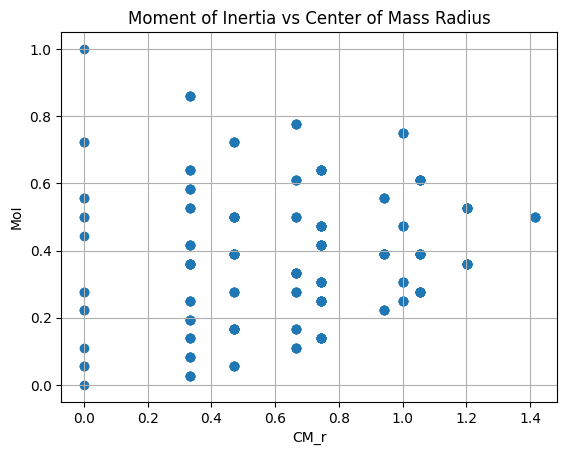

In [20]:
plt.figure()
plt.scatter(df["CM_r"], df["MoI"])
plt.xlabel("CM_r")
plt.ylabel("MoI")
plt.title("Moment of Inertia vs Center of Mass Radius")
plt.grid()
plt.show()

In [ ]:
# 